In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
% cd drive/"My Drive"/Hackathons/Hiring/Totality_corp/NewFolder/

/content/drive/My Drive/Hackathons/Hiring/Totality_corp/NewFolder


### **Importing required Libraries**

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [8]:
from matplotlib.image import imread
import cv2
%matplotlib inline 

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications import vgg16
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

### **Data Ingestion**

In [10]:
image_labels = pd.read_csv("labels.csv")
print(image_labels.shape)
image_labels.head()

(10222, 2)


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [11]:
interested_breeds = ['beagle', 'chihuahua', 'doberman','french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound','tibetan_mastiff']

In [12]:
train_labels = image_labels.loc[image_labels.breed.isin(interested_breeds)]
train_labels.id = train_labels.id.apply(lambda x: f"{x}.jpg")
print(train_labels.shape)
train_labels.head()

(841, 2)


id               breed
4   0021f9ceb3235effd7fcde7f7538ed62.jpg    golden_retriever
9   0042188c895a2f14ef64a918ed9c7b64.jpg  scottish_deerhound
20  008b1271ed1addaccf93783b39deab45.jpg            doberman
25  00a366d4b4a9bbb6c8a63126697b7656.jpg    golden_retriever
37  0100f55e4f0fe28f2c0465d3fc4b9897.jpg    golden_retriever

### **EDA**

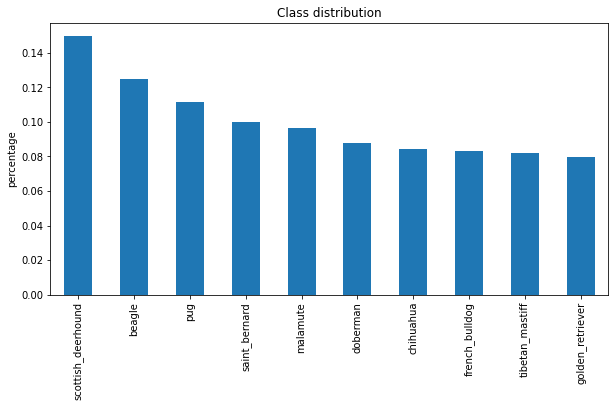

In [13]:
# classwise distribution

train_labels.breed.value_counts(True).plot.bar(figsize=(10,5))
plt.ylabel("percentage")
plt.title("Class distribution")
plt.show()

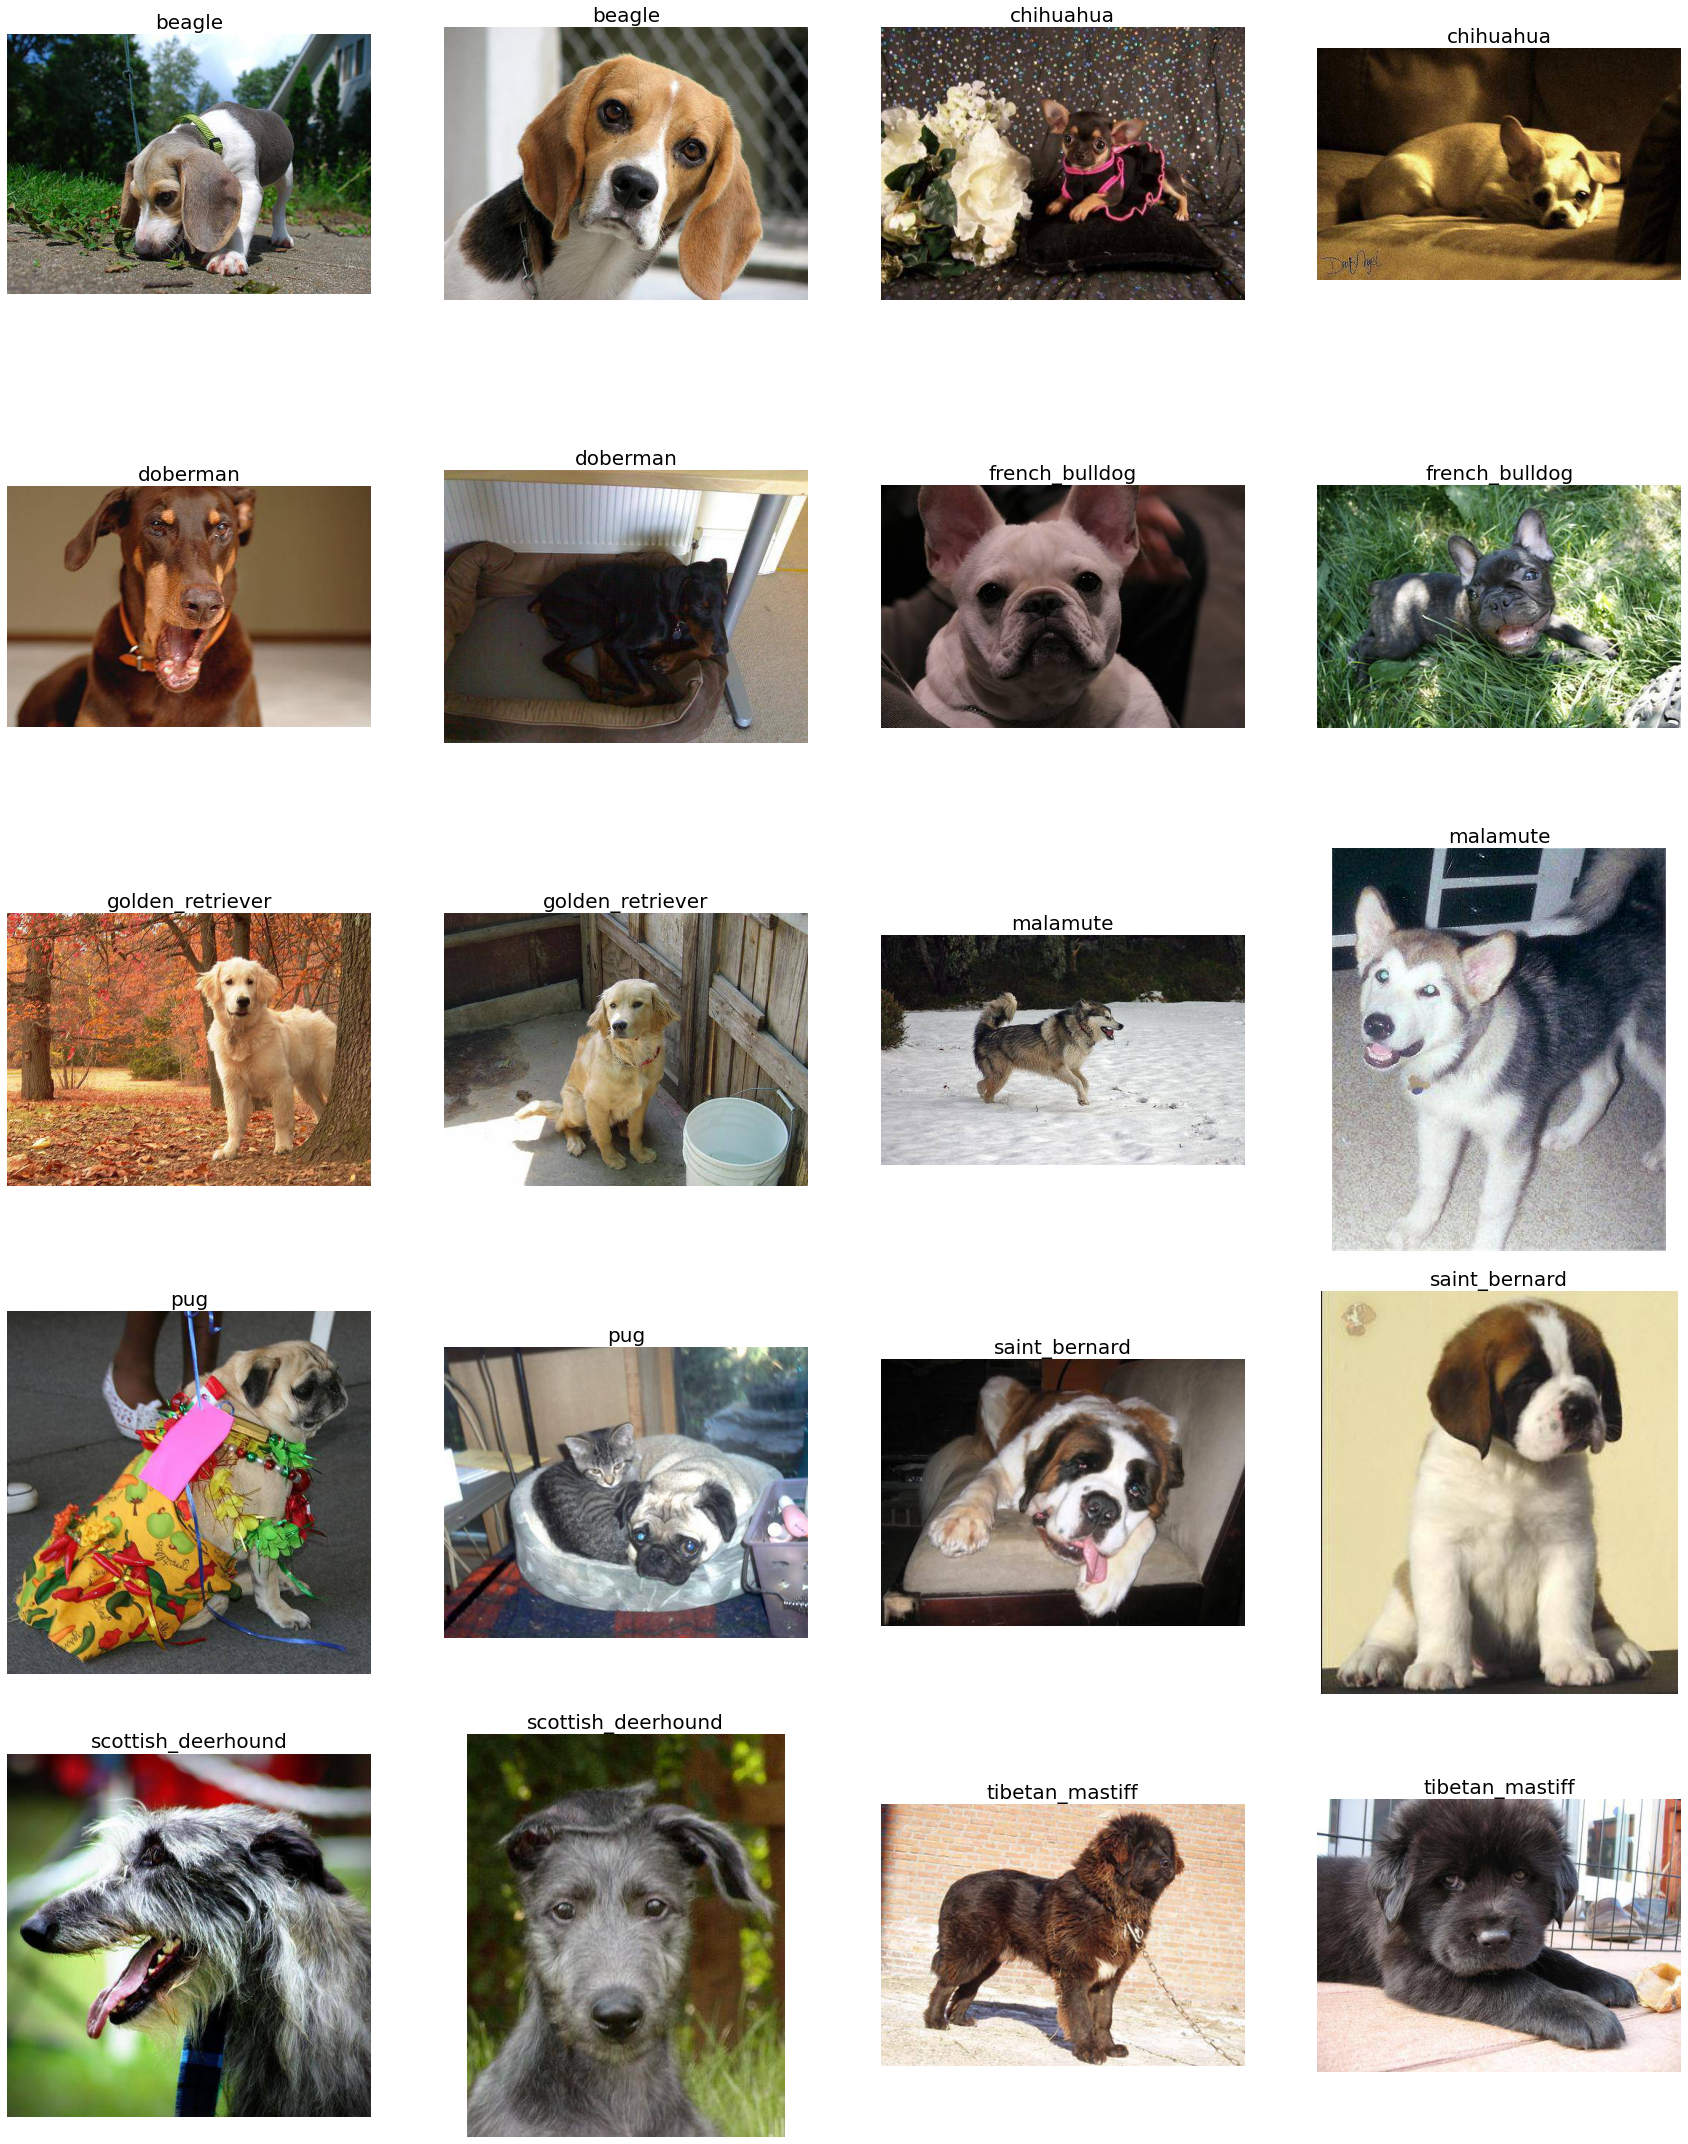

In [14]:
# plotting figures of dogs of different breeds

plt.figure(figsize=(30,40))
for idx,row in train_labels.groupby("breed").sample(2).reset_index(drop=True).iterrows():
    plt.subplot(5,4, idx+1)
    plt.subplots_adjust(hspace=0.1)
    fp = os.path.join("./train", row['id'])
    image = imread(fp)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{row['breed']}", fontsize=20)
plt.show()

### **Model Building**

In [15]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                              validation_split=0.15,
                              rotation_range=20,        # 
                              zoom_range = 0.1,         # Randomly zoom image 
                              width_shift_range=0.1,    # randomly shift images horizontally (fraction of total width)
                              height_shift_range=0.1,   # randomly shift images vertically (fraction of total height)
                              horizontal_flip=True
                            )

In [16]:
train_generator = datagen.flow_from_dataframe(dataframe=train_labels, 
                                              directory="./train/", 
                                              x_col="id", 
                                              y_col="breed",
                                              target_size=(224, 224), 
                                              class_mode="categorical", 
                                              subset="training",
                                              seed=23,
                                              shuffle=True,
                                              batch_size=32)

valid_generator = datagen.flow_from_dataframe(dataframe=train_labels, 
                                              directory="./train/", 
                                              x_col="id", 
                                              y_col="breed",
                                              target_size=(224, 224), 
                                              class_mode="categorical", 
                                              subset="validation",
                                              seed=23,
                                              shuffle=False,
                                              batch_size=32)

Found 715 validated image filenames belonging to 10 classes.
Found 126 validated image filenames belonging to 10 classes.


#### **Using Resnet50**

In [17]:
base_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet',include_top = False, pooling = 'avg')
for layer in base_model.layers:
    layer.trainable = False


94773248/94765736 [==============================] - 1s 0us/step


In [18]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

#### **Adding more layers**

In [19]:
model = Sequential()
model.add(base_model)
# model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(units=1024,activation="relu"))
model.add(Dense(units=512,activation="relu"))
model.add(Dense(units=10, activation="softmax"))


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 26,215,818
Trainable params: 2,628,106
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=adam_opt,
              metrics=['accuracy'])

In [22]:
history = model.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[])

Epoch 1/10
23/23 [==============================] - 204s 7s/step - loss: 1.7445 - accuracy: 0.5268 - val_loss: 0.2756 - val_accuracy: 0.9048
Epoch 2/10
23/23 [==============================] - 12s 529ms/step - loss: 0.1486 - accuracy: 0.9424 - val_loss: 0.1569 - val_accuracy: 0.9444
Epoch 3/10
23/23 [==============================] - 12s 533ms/step - loss: 0.0833 - accuracy: 0.9743 - val_loss: 0.3337 - val_accuracy: 0.8968
Epoch 4/10
23/23 [==============================] - 12s 534ms/step - loss: 0.1098 - accuracy: 0.9573 - val_loss: 0.2645 - val_accuracy: 0.9127
Epoch 5/10
23/23 [==============================] - 12s 521ms/step - loss: 0.0909 - accuracy: 0.9749 - val_loss: 0.2422 - val_accuracy: 0.9206
Epoch 6/10
23/23 [==============================] - 12s 529ms/step - loss: 0.0476 - accuracy: 0.9820 - val_loss: 0.3210 - val_accuracy: 0.8810
Epoch 7/10
23/23 [==============================] - 12s 530ms/step - loss: 0.0346 - accuracy: 0.9902 - val_loss: 0.3291 - val_accuracy: 0.9127
E

#### **Evaluation metrics**

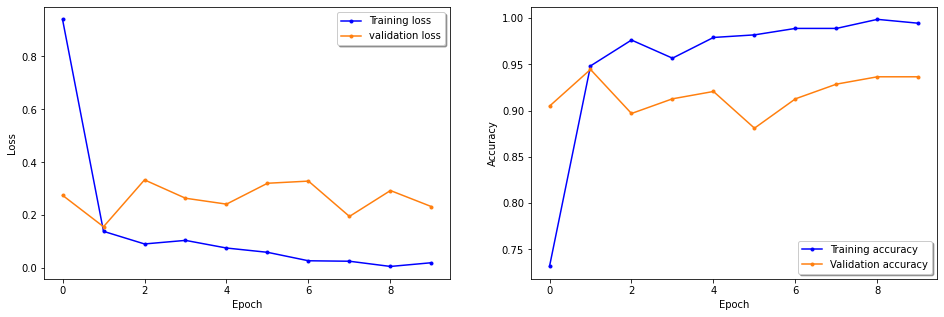

In [23]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(history.history['loss'], color='b', label="Training loss", marker='.')
ax[0].plot(history.history['val_loss'], color='tab:orange', label="validation loss",axes =ax[0], marker='.')
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy", marker='.')
ax[1].plot(history.history['val_accuracy'], color='tab:orange',label="Validation accuracy", marker='.')
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
legend = ax[1].legend(loc='best', shadow=True)

In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, plot_confusion_matrix

Y_pred = model.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)

f_score = f1_score(valid_generator.classes,y_pred,average='macro')
print('F1 score:',f_score)

target_names = np.sort(['beagle', 'chihuahua', 'doberman','french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound','tibetan_mastiff'])

# print('Confusion Matrix')
# print(confusion_matrix(valid_generator.classes, y_pred))
# print('Classification Report')
# print(classification_report(valid_generator.classes, y_pred, target_names=target_names))


F1 score: 0.9440270903553394


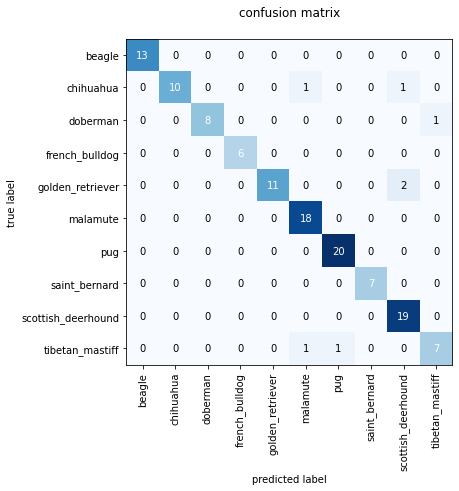

In [39]:
from mlxtend.plotting import plot_confusion_matrix

mat = confusion_matrix(valid_generator.classes, y_pred)
fig,ax = plot_confusion_matrix(conf_mat = mat,figsize=(6,6), show_normed=False)
plt.xticks(np.arange(len(target_names)),target_names,rotation = 90)
plt.yticks(np.arange(len(target_names)),target_names)
plt.title('confusion matrix')
plt.show()


### **Inference Pipeline**

In [40]:
def load_and_preprocess(file_path):
    image = imread(fp)
    # According input shape of model
    resized = cv2.resize(image, (224,224))

    # Convert into 4d (batch lvl as dl need it)
    img_batch = np.expand_dims(resized, axis=0)

    processed_img = preprocess_input(img_batch)
    return processed_img

In [45]:
fp = os.path.join("./test", '0afdd7296357eed0c69a63fb228645d1.jpg')
processed_image = load_and_preprocess(fp)

In [46]:
prediction = model.predict(processed_image)

Model prediction: malamute (0.99999)


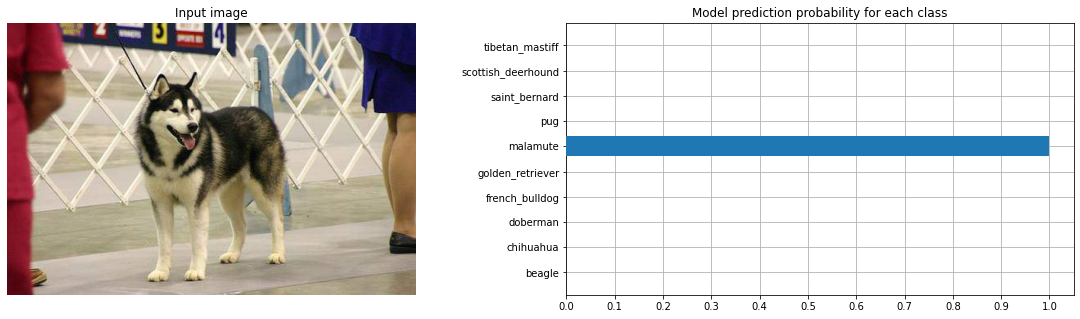

In [47]:
class_labels = np.sort(interested_breeds)
class_pred = np.argmax(prediction, axis=-1)[0]

print(f"Model prediction: {class_labels[class_pred]} ({prediction[0][class_pred]:.5f})")
fig, ax = plt.subplots(1,2, figsize=(20,5))
image = imread(fp)
ax[0].imshow(image)
ax[0].axis("off")
ax[0].set_title("Input image")

ax[1].barh(np.arange(10), prediction[0], zorder=4)
ax[1].set_yticks(np.arange(10))
ax[1].set_yticklabels( np.sort(interested_breeds))
ax[1].set_title("Model prediction probability for each class")
ax[1].set_xticks(np.arange(0,1.1,.1))
ax[1].grid(zorder=-2)
plt.show()